# Readgad.py

This is a notebook designed to read and analyse a `Gadget` snapshot. [Gadget II](http://wwwmpa.mpa-garching.mpg.de/galform/gadget/index.shtml#download) is a code for cosmological *N*-body/SPH simulations of large systems capable of running parallell on multiple cores. It is suitable for simulation galaxies and produces binary snapshots as output.

What we will do in this notebook more specifically is to load the data from a gadget snapshot. We will then analyse it by looking at a few different plots. We will:
1. Calculate and visualise the rotation curve of the galaxy.
2. Create an interactive plot that lets us view the galaxy from the side and from above.
3. Inspect the cartesian velocity distributions.
4. Fit the radial density profile of the galaxy.
5. Compare snapshots taken at different times.
6. Investigate the radial migration of stars near the sun.
7. Look at the redistribution of angular momentum across the galaxy.

This will require certain tools.

### Packages

We will begin by importing the required packages for this notebook.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pynbody
import warnings
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from matplotlib.colors import LogNorm 
from ipywidgets import interactive
warnings.filterwarnings('ignore')

Some of these are familiar such as **`matplotlib`**, **`numpy`**, and **`scipy`**. One package not seen within the course previously is [**`pynbody`**](https://github.com/pynbody/pynbody) which is, according to its website is 
 >*a light-weight, portable, format-transparent analysis framework for N-body and hydrodynamic astrophysical simulations supporting PKDGRAV/Gasoline, Gadget, N-Chilada, and RAMSES AMR outputs.*

It, understandably, fits our needs rather well. 
<!-- Another package is [**`galpy`**](https://arxiv.org/abs/1412.3451), which according to its author Jo Bovy is -->

<!-- >*a Python 2 and 3 package for galactic dynamics. It supports orbit integration in a variety of potentials, evaluating and sampling various distribution functions, and the calculation of action-angle coordinates for all static potentials.* -->

<!-- It will be useful in creating some typical galactic dynamics plots. -->

### Loading the data

Here we will use the pynbody function `load` to read the gadget snapshot. Then we print some information from the snapshots such as what types of data we have (dark matter (dm) and stars), how large the data is, and what type of data we have. 

In [4]:
f = pynbody.load("data/snapshot_100")

print(f.families())
print(len(f))
print(f.loadable_keys())
mass = f['mass'] # Loading snapshot into numpy array [nx1]
pos = f['pos'] # Loading snapshot into numpy array [nx3]
vel = f['vel'] # Loading snapshot into numpy array [nx3]
iord = f['iord'] # Loading snapshot into numpy array [nx1]

[<Family dm>, <Family star>]
130000
['pos', 'mass', 'iord', 'vel']


Here we can see that we have mass, positions ($x$,$y$,$z$), velocities ($v_x$,$v_y$,$v_z$), and indices. The units are $10^{10}$ M$_\odot$, kpc, and  km/s for mass, position, and velocity respectively.

The data consists of three types of particles: dark matter, disc, and bulge. We want to separate these out and can do so by use of their different masses.

In [5]:
m_handles = np.unique(mass)
(disc, bulge, dm) = (mass == m_handles[0], mass == m_handles[1], mass == m_handles[2])

We are now able to select for the particles we want by using any of the above defined masks in the following example manner
> `pos[dm,:]`

if we for example wanted to select the dark matter positions.

We will now calculate some useful things.

In [6]:
(x,y,z) = (pos[:,0],pos[:,1],pos[:,2])
(vx,vy,vz) = (vel[:,0],vel[:,1],vel[:,2])
R = np.sqrt(x**2 + y**2) # Radius
vc = (vy*x - vx*y)/R # Circular velocity

Here we have calculate the radius, which is given by $R = \sqrt{x^2 + y^2}$ in cartesian cordinates and the circular velocity. The circular velocity we can find by calculating the derivative of the angle in cylindrical coordinates. I turns out to be $$v_c = \frac{v_y\cdot x - v_x\cdot y}{R}$$

### Plotting

Next we set some parameters for future plotting

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'];
plt.rcParams.update({'font.size': 18, 'figure.figsize': [6, 6], 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.labelsize': 20, 'figure.frameon': True, 'xtick.direction':'in','ytick.direction':'in'})

### Rotation curve

The first plot we wish to create is the rotation curve of our galaxy. Due to dark matter, the rotation velocity becomes roughly constant at large radii and we expect to see the same behaviour here. To read more click [here](https://en.wikipedia.org/wiki/Galaxy_rotation_curve).

We will use the LOWESS function to fit the behaviour (see lecture 3 on `pandas`), since using all particles in the disc would cause take far too long, we take every 100th disc particle to generate the fit.

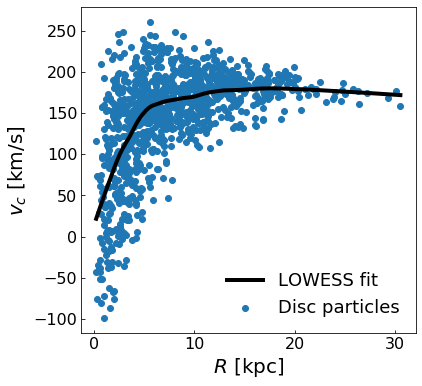

In [8]:
n = 100
R2 = R[disc]
vc2 = vc[disc]
lwfit = lowess(vc2[::n],R2[::n],frac=0.3)

plt.scatter(R2[::n],vc2[::n],lw=1,color=colors[0],label='Disc particles')
plt.plot(lwfit[:,0], lwfit[:,1],lw=4, color='k',label='LOWESS fit')
plt.xlabel('$R$ [kpc]')
plt.ylabel('$v_c$ [km/s]')
plt.legend(frameon=False,loc=4)
plt.show()

### Visualising the galaxy

Now that we've seen a somewhat believable rotation curve, let us look at the galaxy in two ways, edge-on and face-on. What we do now is create density contour plots. Since we use a lot of data, we also bin once more. Here we make use of such functions from `numpy` as `histogram2d` and `meshgrid` to create 2D arrays. 

Once this is done we use `matplotlib` to find functions like `subplots` and `contourf`. At the end, we create an interactive plot to show the difference in using many or few contour lines. For visuals, we also allow it to be rotated. For this we first define a function to rotate which is simply the [rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix).

In [9]:
def rotate(x,y,deg):
    theta = np.radians(deg)
    x2 = x*np.cos(theta) - y*np.sin(theta)
    y2 = x*np.sin(theta) + y*np.cos(theta)
    return x2,y2

In the next codeblock we use `np.meshgrid()` which is a function that allows us to create a matrix from two vectors. We need this together with the 2D histogram function `np.histogram2d()` in order to be able to generate a contour plot with `plt.contourf()`.

In [10]:
def plot_gal(contours=8,deg=0):
    (x_rot,y_rot) = rotate(x,y,deg)
    # Binning
    (x2,y2) = (x_rot[disc],y_rot[disc])
    N1,yedges,xedges = np.histogram2d(y2,x2,100,range=[[-30,30], [-30,30]])
    xc = (xedges[:-1] + xedges[1:]) / 2; yc = (yedges[:-1] + yedges[1:]) / 2 
    X1,Y = np.meshgrid(xc,yc) 

    (x2,z2) = (x_rot[disc],z[disc])
    N2,zedges,xedges = np.histogram2d(z2,x2,100,range=[[-10,10], [-30,30]])
    xc = (xedges[:-1] + xedges[1:]) / 2; zc = (zedges[:-1] + zedges[1:]) / 2
    X2,Z = np.meshgrid(xc,zc)


    f, axes = plt.subplots(1, 2,figsize=(12,5))
    #Face-on view
    axes[0].set_xticks(np.arange(-30,30,10))
    c = axes[0].contourf(X1,Y,np.log10(N1 + 1),contours)
    axes[0].set_xlabel('$x$ [kpc]')
    axes[0].set_ylabel('$y$ [kpc]')
    axes[0].set_title('Face-on view')
    f.colorbar(c, ax=axes[0],label=('$\log(N)$'))
    # Edge-on view
    axes[1].set_xticks(np.arange(-30,30,10))
    c = axes[1].contourf(X2,Z,np.log10(N2 + 1),contours)
    axes[1].set_xlabel('$x$ [kpc]')
    axes[1].set_ylabel('$z$ [kpc]')
    axes[1].set_title('Edge-on view')
    f.colorbar(c, ax=axes[1],label=('$\log(N)$'))
    plt.tight_layout()

    plt.show()

In [11]:
interactive_plot = interactive(plot_gal, contours=(1,20,3), deg=(0,360,10))
interactive_plot.children[0].description='# Contours'
interactive_plot.children[1].description='Rotation shift'
interactive_plot

interactive(children=(IntSlider(value=8, description='# Contours', max=20, min=1, step=3), IntSlider(value=0, description='Rotation shift', max=360, step=10), Output()), _dom_classes=('widget-interact',))

We end up with an interactive plot that can be rotated along the $z$-axis and in which the amount of contours can be changed.

### Velocity distributions

We work with velocities and positions and it is useful to find out how these are distributed within the simulation. Next we will look at the velocity distributions in $x$, $y$, and $z$.

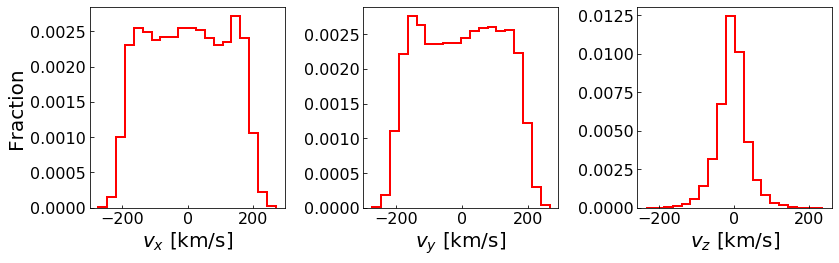

In [12]:
bins = 20
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,4))
ax1.hist(vx[disc],bins, lw=2, histtype='step',normed=True, color='r')
ax1.set_ylabel('Fraction')
ax1.set_xlabel('$v_x$ [km/s]')
ax2.hist(vy[disc],bins, lw=2, histtype='step',normed=True, color='r')
ax2.set_xlabel('$v_y$ [km/s]')
ax3.hist(vz[disc],bins, lw=2, histtype='step',normed=True, color='r')
ax3.set_xlabel('$v_z$ [km/s]')
plt.tight_layout()
plt.show()

We can see some interesting features such as the double-peaked distributions in $v_x$ and $v_y$. Since the circular velocity becomes constant at some radial distance, this is not very surprising. $v_z$ is somewhat more normally distributed.

### Density profile

What about the radial distribution of stars in our Galaxy? From the contour plot above we expect the number of stars to increase towards smaller radii. Let us investigate the radial distribution to find out. On top of this, we will use the `scipy` package to fit a $\gamma$-distribution using least-squares. The function for the probability distribution function (pdf) of $\gamma$ is `scipy.stats.gamma.pdf()`.

In [13]:
def gamma(x,a,loc,scale):
    return scipy.stats.gamma.pdf(x, a, loc, scale)

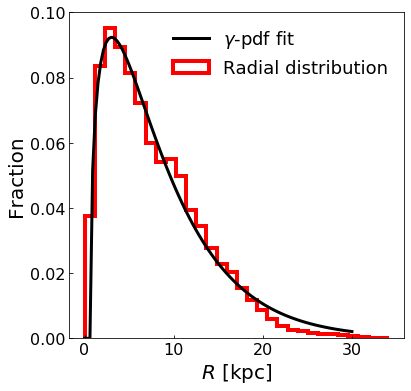

In [14]:
H = plt.hist(R[disc],30,histtype='step',normed=True,lw=4,color='r',label='Radial distribution')
(values,edges) = (H[0],H[1])
E = edges[:-1]+(edges[1]-edges[0])/2.
popt,pcov = scipy.optimize.curve_fit(gamma, E, values, p0=(1,2,3),bounds = (0, 20))

plt.plot(np.linspace(0,30,100),gamma(np.linspace(0,30,100),popt[0],popt[1],popt[2]),lw=3,color='k',label='$\gamma$-pdf fit')
plt.xlabel('$R$ [kpc]')
plt.ylabel('Fraction')
plt.legend(frameon=False,loc=0)
plt.show()


### Comparisons

Up until now, we've looked at individual snapshots. But for studies of how galaxies evolve it is necessary to compare snapshots taken at different times. For this we'll use the snapshots `snapshot_000` and `snapshots_100` taken 1 Gyr apart. We'll calculate the difference in angular momentum, $\Delta L_z$, which is a measure of radius. Through this, we might be able to identify spiral patterns. We use specific angular momentum in the $z$ direction which is calculated using the equation:
$$L_z = x\cdot v_y - y\cdot v_x$$

In [15]:
i = pynbody.load("data/snapshot_000"); f = pynbody.load("data/snapshot_100")

pos_i = i['pos']; pos_f = f['pos'] # Loading snapshot into numpy array [nx3]
vel_i = i['vel']; vel_f = f['vel'] # Loading snapshot into numpy array [nx3]
(xi,yi,zi,xf,yf,zf) = (pos_i[:,0],pos_i[:,1],pos_i[:,2],pos_f[:,0],pos_f[:,1],pos_f[:,2])
(vxi,vyi,vzi,vxf,vyf,vzf) = (vel_i[:,0],vel_i[:,1],vel_i[:,2],vel_f[:,0],vel_f[:,1],vel_f[:,2])
lzi = xi*vyi - xi*vxi
lzf = xf*vyf - yf*vxf
dlz = lzf - lzi

Now we plot the change in angular momentum $\Delta L_z$ against the initial angular momentum $L_{z,i}$. What the following plot will then show is radial migration. 

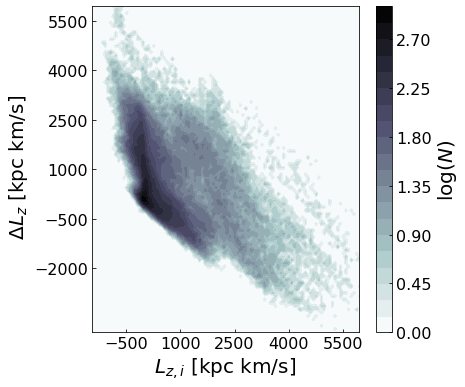

In [16]:
(dlz2,lzi2) = (dlz[disc],lzi[disc])
N,yedges,xedges = np.histogram2d(dlz2,lzi2,100,range=[[-4000,6000], [-1500,6000]])
xc = (xedges[:-1] + xedges[1:]) / 2; yc = (yedges[:-1] + yedges[1:]) / 2 
LZI,DLZ = np.meshgrid(xc,yc)

plt.xticks(np.arange(-2000,6000,1500))
plt.yticks(np.arange(-2000,6000,1500))
c = plt.contourf(LZI,DLZ,np.log10(N + 1),20,cmap='bone_r')
plt.xlabel('$L_{z,i}$ [kpc km/s]')
plt.ylabel(' $\Delta L_z$ [kpc km/s]')
plt.colorbar(label='$\log(N)$')
plt.show()

The diagonal features here can be due to the existence of spiral arms. For a detailed explanation read [here](https://lup.lub.lu.se/student-papers/search/publication/8924746).

### Solar neighbourhood

Now that we have a comparison, it might be interesting to see how stars in the solar neighbourhood, that is stars close to 8 kpc, have migrated. We can easily do this by plotting a histogram of all the stars that had initial radius $R_i$ between say 7-9 kpc.

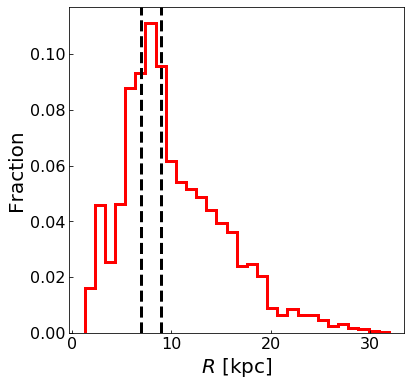

In [19]:
Ri = np.sqrt(xi[disc]**2 + yi[disc]**2)
Rf = np.sqrt(xf[disc]**2 + yf[disc]**2)
I = (Ri > 7) & (Ri < 9)
Rf_snhd = Rf[I]

plt.hist(Rf_snhd,30,histtype='step',normed=True,lw=3,color='r')
plt.axvline(x=7,lw=3,color='k',ls='dashed')
plt.axvline(x=9,lw=3,color='k',ls='dashed')
plt.xlabel('$R$ [kpc]')
plt.ylabel('Fraction')
plt.show()

We add some vertical dashed lines with `plt.axvline()` to indicate the original region from which the stars are sampled. We can see that there is a rather significant redistribution of positions.


We can of course look at the distributions in $L_z$ as well and compare the overall initial state of the galaxy to the final state. Without a simply translation between radius and angular momentum however it is difficult to restrict this to the solar neighbourhood.

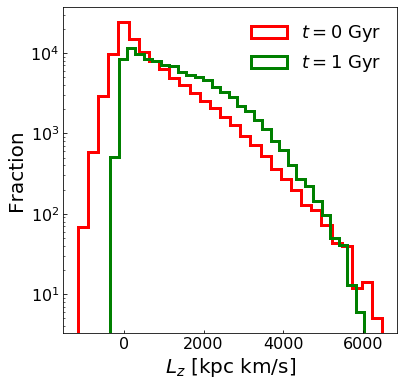

In [20]:
plt.hist(lzi[disc],30,histtype='step',lw=3,color='r',label='$t=0$ Gyr')
plt.hist(lzf[disc],30,histtype='step',lw=3,color='g',label='$t=1$ Gyr')
plt.xlabel('$L_z$ [kpc km/s]')
plt.ylabel('Fraction')
plt.yscale('log')
plt.legend(frameon=False,loc=0)
plt.show()

With this, we have performed an analysis of the given data which has positions and velocities. Mass is the same for particles of the same type (dark matter, disc, or bulge) so it is not particularly interesting to look at. There are much more advanced methods of analysis that could be performed such as the identification of which fourier modes are present and their amplitude in the disc. This essentially asks the question of how many spiral arms there are and what their strength is. We could also calcualte action-angle coordinates if we knew the potential of the galaxy. The potential could be deduced. These other exercises are however somewhat beyond the scope of this course and therefore we do not perform them here and stop at this point. 

Thank you for reading my notebook,

Daniel